# I. Import Libraries and Data

### Key Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 

### Read Datasets

To answer questions a-e, I know that I need the following fields from the following tables:
results:
raceId, driverId, constructorId, number, positionOrder, points, fastestLapTime, rank
races: raceId, year, 
constructors: 

In [2]:
import os 
base_dir = os.getcwd()
#"/Users/gracebarringer/qtm530fall2024/Lecture 03/data_raw" # 

import os 
base_dir = os.getcwd()
file_path = os.path.normpath(os.path.join(base_dir, "../../", "Lecture 03/data_raw/"))


results_file_path = os.path.join(file_path, "results.csv")
races_file_path = os.path.join(file_path, "races.csv")
constructors_file_path = os.path.join(file_path, "constructors.csv")
drivers_file_path = os.path.join(file_path, "drivers.csv")


results = pd.read_csv(results_file_path)
races = pd.read_csv(races_file_path)
constructors = pd.read_csv(constructors_file_path)
drivers = pd.read_csv(drivers_file_path)



# II. Cleaning Data 

Questions for Dr. Sánchez Becerra
1. Should I clean all fields of the data or just the ones I am going to use? For example, if I'm not planning on using the milliseconds field in the results table, do I still need to convert it to the correct data type? What about missing values?
2. How thorough do my checks for data cleaning and validation need to be? For example, in the races table, can I assume that the values in the year column match the year specified in the date column?
    Should I have checks for every new table I create?

5. Should I check for outliers before or after the data is filtered and aggregated? For example, if I am using the points field in the results table but aggregating it across constructors and only for specific years, should I look at the point outliers of my new table or the original results table or both?

7. Structure of code
8. What was it that we should comment out vs. what we should show in our submission?

## results table

##### 1.\) Checking for correct data types and fixing incorrect data types.
I want to ensure that all columns in the results table are the same types as what is shown in the f1_codebook and fix them if they are not.

In [3]:
# Checking to ensure the data types match what's expected 
results.dtypes

resultId             int64
raceId               int64
driverId             int64
constructorId        int64
number              object
grid                 int64
position            object
positionText        object
positionOrder        int64
points             float64
laps                 int64
time                object
milliseconds        object
fastestLap          object
rank                object
fastestLapTime      object
fastestLapSpeed     object
statusId             int64
dtype: object

number, position, milliseconds, fastestLap, and rank don't match the data types in the f1_codebook - they are showing as objects in this table but should be integers. They are showing up as objects because there is at least one non-numeric value in each of the columns. Although I will not be using all of these columns in my analysis, I still to ensure they are all of the correct data type. Next, I will check to see what the non-numeric value(s) is (are) in each column.

In [4]:
# Checking to see non-numeric values in each column  

subset_num = results.query("number.str.isnumeric() == False")
print("number: ", pd.unique(subset_num["number"]))

subset_pos = results.query("position.str.isnumeric() == False")
print("position: ", pd.unique(subset_pos["position"]))

subset_ms = results.query("milliseconds.str.isnumeric() == False")
print("milliseconds: ", pd.unique(subset_ms["milliseconds"]))

subset_fl = results.query("fastestLap.str.isnumeric() == False")
print("fastestLap: ", pd.unique(subset_fl["fastestLap"]))

subset_r = results.query("rank.str.isnumeric() == False")
print("rank: ", pd.unique(subset_r["rank"]))

number:  ['\\N']
position:  ['\\N']
milliseconds:  ['\\N']
fastestLap:  ['\\N']
rank:  ['\\N']


'\\\N' is the non-numeric value showing up across all columns listed above, so I will now use the .replace method to replace this value with NaN and convert the columns to integers. 


In [5]:
# Replacing non-numeric values with NaN and converting the column to type Int64

results["number"] = results["number"].replace('\\N', np.nan)
results["number"] = pd.to_numeric(results["number"]).astype('Int64')

results["position"] = results["position"].replace('\\N', np.nan)
results["position"] = pd.to_numeric(results["position"]).astype('Int64')

results["milliseconds"] = results["milliseconds"].replace('\\N', np.nan)
results["milliseconds"] = pd.to_numeric(results["milliseconds"]).astype('Int64')

results["fastestLap"] = results["fastestLap"].replace('\\N', np.nan)
results["fastestLap"] = pd.to_numeric(results["fastestLap"]).astype('Int64')

results["rank"] = results["rank"].replace('\\N', np.nan)
results["rank"] = pd.to_numeric(results["rank"]).astype('Int64')

I know that I want to look at fastestLapTime and fastestLapSpeed when determining Ferrari's best year, so I'm going to go ahead and convert the fastestLapTime to milliseconds and make it an integer, and convert fastestLapSpeed into an integer. 

First, I'm going to see if there are any non-

In [55]:
subset_fastestLapTime= results.query("fastestLapTime.str.isnumeric() == False")
print("fastestLapTime: ", pd.unique(subset_fastestLapTime["fastestLapTime"]))

fastestLapTime:  ['1:27.452' '1:27.739' '1:28.090' ... '1:29.788' '1:30.309' '1:30.579']


In [54]:
# Convert the 'time' column into milliseconds using a lambda function
results['fastestLapTime_ms'] = results['fastestLapTime'].apply(lambda x: int(x.split(':')[0]) * 60 * 1000 +  # minutes to milliseconds
                                                int(x.split(':')[1].split('.')[0]) * 1000 +  # seconds to milliseconds
                                                int(x.split(':')[1].split('.')[1])) 
display(results)

ValueError: invalid literal for int() with base 10: '\\N'

##### 2.\) Checking for duplicates 
In the results table, I want to ensure that there are no duplicate records because each row should be a unique record

In [6]:
print("Duplicate rows in results table: ", results[results.duplicated()])

Duplicate rows in results table:  Empty DataFrame
Columns: [resultId, raceId, driverId, constructorId, number, grid, position, positionText, positionOrder, points, laps, time, milliseconds, fastestLap, rank, fastestLapTime, fastestLapSpeed, statusId]
Index: []


There are no duplicate rows in the results table.

##### 3.\) Checking for missing values
Now that all of my columns are of the correct type and I've checked for duplicate records, I want to see which columns have missing values and count how many values are missing for each column in the results table. If many values are missing in a column that I plan on using, I might need to decide on a method to impute the values. 


Now that all of my columns are of the correct type, I want to count how many values each column in the results table are missing. If many values are missing in a column that I plan on using, I might need to decide on a method to impute the values. 

NaN represents a missing value in my int or float columns so I will use .isna() to count how many missing values there are in these columns. 

For object columns, I will use .isnull() to determine if any values are missing (not that isnull just checks for NULLs, but if the value makes sense or not)

In [7]:
# getting list of column names 
results_cols_all = results.columns.tolist()
# getting list of column names for numeric variables 
results_cols_num = results.select_dtypes(include = ['number']).columns.tolist()
# getting list of column names for object variables 
results_cols_obj = results.select_dtypes(include = ['object']).columns.tolist()

# count and print the missing values of each numeric column 
for i in results_cols_num:
    print("Missing value count ", i, ": ", results[i].isna().sum())

for i in results_cols_obj:
    print("Missing value count ", i, ": ", results[i].isnull().sum())


Missing value count  resultId :  0
Missing value count  raceId :  0
Missing value count  driverId :  0
Missing value count  constructorId :  0
Missing value count  number :  6
Missing value count  grid :  0
Missing value count  position :  10851
Missing value count  positionOrder :  0
Missing value count  points :  0
Missing value count  laps :  0
Missing value count  milliseconds :  18753
Missing value count  fastestLap :  18461
Missing value count  rank :  18249
Missing value count  statusId :  0
Missing value count  positionText :  0
Missing value count  time :  0
Missing value count  fastestLapTime :  0
Missing value count  fastestLapSpeed :  0


The only field that has missing values that I might be using is rank. I will only be using rank in the context of Ferrari between 1981 and 2020. Once I create the merged dataframe with my needed fields (in part III), I will check to see if any values are missing in rank for Ferrari between 1981 and 2020. 

Questions: 
About ferrari being "best" - when to see if ferarri is missing values for what I might uyse for "best"
About if I should look at description now or way until aggregated 



##### 4.\) soemthing about uniqueness

### races table

##### 1.\) Checking for correct data types and fixing incorrect data types.
I want to ensure that all columns in the races table are the same types as what is shown in the f1_codebook and fix them if they are not.

In [8]:
# Checking to ensure the data types match what's expected 
races.dtypes

raceId          int64
year            int64
round           int64
circuitId       int64
name           object
date           object
time           object
url            object
fp1_date       object
fp1_time       object
fp2_date       object
fp2_time       object
fp3_date       object
fp3_time       object
quali_date     object
quali_time     object
sprint_date    object
sprint_time    object
dtype: object

The column types in the races table match the codebook. 

##### 2.\) Checking for duplicates
raceId in the races table should be unique, and since I will be using the raceId in the races table to pull in year to the results table, I want to ensure that each raceId is unique in the races table

In [9]:
print("Duplicate raceId in races table: ", races[races['raceId'].duplicated()])

# I could also verify this by ensuring the count of rows in the dataframe equals the count of unique raceIds, or count how many times a raceId occurs and filter to count > 1

Duplicate raceId in races table:  Empty DataFrame
Columns: [raceId, year, round, circuitId, name, date, time, url, fp1_date, fp1_time, fp2_date, fp2_time, fp3_date, fp3_time, quali_date, quali_time, sprint_date, sprint_time]
Index: []


##### 3.\) Checking for missing values
Because I will be using the races table to pull in the year to the results table on raceId, I want to ensure that raceId and year are not missing any values. 

In [10]:
print("Missing value count raceId: ", races['raceId'].isna().sum())
print("Missing value count year: ", races['year'].isna().sum())

Missing value count raceId:  0
Missing value count year:  0


### constructors table

##### 1.\) Checking for correct data types and fixing incorrect data types.
I want to ensure that all columns in the constructors table are the same types as what is shown in the f1_codebook and fix them if they are not.

In [11]:
# Checking to ensure the data types match what's expected 
constructors.dtypes

constructorId      int64
constructorRef    object
name              object
nationality       object
url               object
dtype: object

The column types in the constructors table match the codebook. 

##### 2.\) Checking for duplicates
I want to ensure that there are no duplicate constructorId values in the constructor table, and I want to ensure that there are no duplicate name values in the constructors table

In [12]:
# checking for duplicate constructorIds
print("Duplicate constructorIds in constructors table: ", constructors[constructors['constructorId'].duplicated()])

# To ensure no duplicate names, I need to normalize the name values to ensure that duplicate names are recognized if they exist (put all in lowercase and remove all white space)
constructors['normalizedName'] = constructors['name'].str.lower().str.strip()

print("Duplicate names in constructors table: ", constructors[constructors['normalizedName'].duplicated()])



Duplicate constructorIds in constructors table:  Empty DataFrame
Columns: [constructorId, constructorRef, name, nationality, url]
Index: []
Duplicate names in constructors table:  Empty DataFrame
Columns: [constructorId, constructorRef, name, nationality, url, normalizedName]
Index: []


constructorId values and name values are each unique 

##### 3.\) Checking for missing values
Because I will be using the constructs table to pull in the names to the results table on constructorId, I want to ensure that  constructorId and name are not missing any values. 

In [13]:
print("Missing value count constructorId: ", constructors['constructorId'].isna().sum())
print("Missing value count name: ", constructors['name'].isnull().sum())

Missing value count constructorId:  0
Missing value count name:  0


Neither constructorId nor name are missing values from the constructors table, which is what I expected given the fact that there were no duplicates (unless just missing 1 value)

### drivers table

##### 1.\) Checking for correct data types and fixing incorrect data types.
I want to ensure that all columns in the drivers table are the same types as what is shown in the f1_codebook and fix them if they are not.

In [14]:
# Checking to ensure the data types match what's expected 
drivers.dtypes

driverId        int64
driverRef      object
number         object
code           object
forename       object
surname        object
dob            object
nationality    object
url            object
dtype: object

number does not match the data type in the codebook - it is showing as an object in this table but should be an integer. It is showing up as an object because there is at least one non-numeric value in the column. Next, I will check to see what the non-numeric value(s) is (are) in the column

In [15]:
# Checking to see non-numeric values in the column  
drivers_subset_num = drivers.query("number.str.isnumeric() == False")
print(pd.unique(drivers_subset_num["number"]))

['\\N']


'\\\N' is the non-numeric value showing up in the number column, so I will now use the .replace method to replace this value with NaN and convert the column to be type integer

In [16]:
drivers["number"] = drivers["number"].replace('\\N', np.nan)
drivers["number"] = pd.to_numeric(drivers["number"]).astype('Int64')

In [17]:
# Verifying that the number column is now type integer
drivers.dtypes

driverId        int64
driverRef      object
number          Int64
code           object
forename       object
surname        object
dob            object
nationality    object
url            object
dtype: object

##### 2.\) Checking for duplicates
I want to ensure that there are no duplicate driverId values in the drivers table, and I want to ensure that there are no duplicate driver names (I will create a new variable fullName to combine forename and surname). In the drivers table, each driver should be represented in one row. Furthermore, each driver should have a unique driverId associated with them (number to driver should be a one-to-one mapping). 

In [18]:
# Check to see the number of rows in the dataset 
# print("drivers shape: ", drivers.shape)
# print("count of unique driverId: ", drivers['driverId'].nunique())
print("Duplicate driverId in drivers table: ", drivers[drivers['driverId'].duplicated()])

# # Combine drivers forename and surname to get unique driver name (in case some drivers have the same forename or the same surname)
drivers['fullName'] = drivers['forename'] + " " + drivers['surname']
drivers['normalizedName'] = drivers['fullName'].str.lower().str.strip()
print("Duplicate fullName in drivers table: ", drivers[drivers['normalizedName'].duplicated()])

# print("count of unique driverId: ", drivers['driverId'].nunique())

Duplicate driverId in drivers table:  Empty DataFrame
Columns: [driverId, driverRef, number, code, forename, surname, dob, nationality, url]
Index: []
Duplicate fullName in drivers table:  Empty DataFrame
Columns: [driverId, driverRef, number, code, forename, surname, dob, nationality, url, fullName, normalizedName]
Index: []


There are no duplicate driverId values or fullName values

##### 3.\) Check for missing values

### All tables - checking for join integrity 

In order to answer the questions in the homework, I will need to joins to pull in needed fields into the results table. 

For questions a, b, and c, I will be pulling in year from the races table into the results table joining on raceId. This will allow me to aggregate the data I need by year, which is currently not in the results table. I need to ensure that there are no raceIds in the results table that are not in the races table. 

For questions a, b, and c, I will also be pulling in name from the constructors table into the results table joining on constructorId. This will allow me to display my data using the constructor name, which is not currently in the results table. I need to ensure that there are no constructorIds in the results table that are not in the constructors table. 



In [19]:
# Checking that all raceIds in the results table are in the races table 
missing_raceId = results[~results['raceId'].isin(races['raceId'])]
if missing_raceId.empty:
    print("All raceId values in the results table are in the races table")
else:
    print("There are raceId values in the results table that are not in the races table")


# Checking that all constructorIds in the results table are in the constructors table 
missing_constructorId = results[~results['constructorId'].isin(constructors['constructorId'])]
if missing_constructorId.empty:
    print("All constructorId values in the results table are in the constructors table")
else:
    print("There are constructorId values in the results table that are not in the constructors table")


All raceId values in the results table are in the races table
All constructorId values in the results table are in the constructors table


# III. Creating needed dataframes for questions


### Creating merged "master" dataframe from which I can use to answer the questions

In [45]:
# Pulling year into results data using a join on raceId and selecting only needed columns 
results_merged = pd.merge(results[['raceId', 'constructorId', 'driverId', 'positionOrder','points', 'fastestLapTime', 'rank']],
                       races[["raceId", "year"]],
                       on = "raceId",
                       how = "left")

# Pulling in constructor name from the constructors table 
results_merged = pd.merge(results_merged, constructors[['constructorId', 'name']], 
                          on = "constructorId",
                          how = "left")

# Pulling in driver fullnames from the drivers table 
results_merged = pd.merge(results_merged, drivers[['driverId', 'fullName']], 
                          on = "driverId",
                          how = "left")

### Quality checks for merged "master" dataframe

#### Ensure row count in results_merged is the same as the results table

In [21]:
print('Number of rows in results: ', results.shape[0])
print('Number of rows in results_merged: ', results_merged.shape[0])

Number of rows in results:  25840
Number of rows in results_merged:  25840


Both the results_merged table and the results table have the same count of rows indicating that no rows were added or removed during the join.

#### Ensure that no data was lost, gained or altered during the join by comparing the descriptive statistics of results_merged to those of results

In [47]:
display(results[['raceId', 'constructorId', 'driverId', 'positionOrder', 'points', 'fastestLapTime', 'rank']].describe())
display(results_merged.describe())


,raceId,constructorId,driverId,positionOrder,points,rank
count,25840.000000,25840.000000,25840.000000,25840.000000,25840.000000,7591.0
mean,531.425813,48.628328,261.732082,12.876006,1.877053,10.409959
std,299.440908,59.732131,268.623016,7.712391,4.169849,6.162407
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.0
25%,293.000000,6.000000,56.000000,6.000000,0.000000,5.0
50%,514.000000,25.000000,163.000000,12.000000,0.000000,10.0
75%,784.000000,58.000000,360.000000,18.000000,2.000000,16.0
max,1096.000000,214.000000,856.000000,39.000000,50.000000,24.0


,raceId,constructorId,driverId,positionOrder,points,rank,year
count,25840.000000,25840.000000,25840.000000,25840.000000,25840.000000,7591.0,25840.000000
mean,531.425813,48.628328,261.732082,12.876006,1.877053,10.409959,1990.251780
std,299.440908,59.732131,268.623016,7.712391,4.169849,6.162407,19.345632
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.0,1950.000000
25%,293.000000,6.000000,56.000000,6.000000,0.000000,5.0,1976.000000
50%,514.000000,25.000000,163.000000,12.000000,0.000000,10.0,1990.000000
75%,784.000000,58.000000,360.000000,18.000000,2.000000,16.0,2007.000000
max,1096.000000,214.000000,856.000000,39.000000,50.000000,24.0,2022.000000


The distributions are the same between both tables so I am comfortable that the join was executed correctly. 

A few notes: 
- None of the fields are missing values besides rank 
- points has 

#### Checking for missing values in rank for Ferrari between 1981 and 2020

In [24]:
ferrari_1981_2020 = results_merged.query("(year >= 1981) & (year <= 2020) & (name == 'Ferrari')")

print("Missing value count rank: ", ferrari_1981_2020['rank'].isna().sum())

# display(ferrari_1981_2020)

Missing value count rank:  738


### Creating and validating needed aggregated data frames for each question

#### Question a

##### Creating data frame

In [25]:
# Created new dataframe with constructor points by year 
constructors_agg = (results_merged.groupby(["constructorId", "name", "year"]).agg(points_by_year = ('points','sum'))).reset_index()

# Querying for just years between 1981 and 2020, aggregating points by constructorId, and sorting by total points by constructor 
# Note: I am also getting the number of distinct years that each constructor competed during the time frame 
constructor_points_1981_2020 = (constructors_agg.query("(year >= 1981) & (year <= 2020)").groupby(["constructorId", "name"]).agg(total_points_1981_2020 = ('points_by_year','sum'), distinct_years = ('year', 'nunique')).sort_values(by = 'total_points_1981_2020', ascending = False)).reset_index()



##### Checking data frame

In [28]:
# Checking for duplicates 

# Ensuring we have the correct number of rows 
# During the time period 1981 and 2020, I would expect the number of constructors to be computed by this: 
constructor_count_1981_2020 = results_merged.query("(year >= 1981) & (year <= 2020)")['constructorId'].nunique()
# Since the constructor_points_1981_2020 table is aggregated at the constructor level, I expect that the number of rows in that table should be equal to constructor_count_1981_2020
if constructor_count_1981_2020 == constructor_points_1981_2020.shape[0]:
    print('Row count check passed')
else:
    print('Row count check failed')


# # Looking at data (descriptions)
# display(constructor_points_1981_2020.describe())

Row count check passed


#### Question b

##### Creating data frame

In [29]:
# Note: using constructors_agg from question a

# Querying for just years between 2001 and 2020, aggregating points by constructorId, and sorting by total points by constructor 
# Note: I am also getting the number of distinct years that each constructor competed during the time frame 
constructor_points_2001_2020 = (constructors_agg.query("(year >= 2001) & (year <= 2020)").groupby(["constructorId", "name"]).agg(total_points_2001_2020 = ('points_by_year','sum'), distinct_years = ('year', 'nunique')).sort_values(by = 'total_points_2001_2020', ascending = False)).reset_index()


##### Checking data frame

Note: 
- Will be using analysis from questions a and b to answer question c
- Will be using results_merged to compute question d directly


#### Question e



There are a few different metrics I want to look at to determine Ferrari's best year between 1981 and 2020:
- Total number of points accumulated in each year - directly indicates performance in each season
- Average number of points per race in each year 
- The number of races won in each year (also show relative to total races) - measure of dominance
- The number of total podium finishes in each year (also show relative to total races) - measure of consistency 
- The fastestLap for each year - could be an indicator of Ferrari's potential speed

##### Creating data frame

In [ ]:



constructors_agg = (results_merged.groupby(["constructorId", "name", "year"]).agg(total_points_by_year = ('points','sum'), avg_points_by_year = ('points', 'mean'), '')).reset_index()


In [40]:
display(results_merged)

,raceId,constructorId,driverId,positionOrder,points,fastestLapTime,rank,year,name,fullName
0,18,1,1,1,10.0,1:27.452,2,2008,McLaren,Lewis Hamilton
1,18,2,2,2,8.0,1:27.739,3,2008,BMW Sauber,Nick Heidfeld
2,18,3,3,3,6.0,1:28.090,5,2008,Williams,Nico Rosberg
3,18,4,4,4,5.0,1:28.603,7,2008,Renault,Fernando Alonso
4,18,1,5,5,4.0,1:27.418,1,2008,McLaren,Heikki Kovalainen
...,...,...,...,...,...,...,...,...,...,...
25835,1096,210,854,16,0.0,1:29.833,12,2022,Haas F1 Team,Mick Schumacher
25836,1096,210,825,17,0.0,1:31.158,20,2022,Haas F1 Team,Kevin Magnussen
25837,1096,131,1,18,0.0,1:29.788,11,2022,Mercedes,Lewis Hamilton
25838,1096,3,849,19,0.0,1:30.309,14,2022,Williams,Nicholas Latifi


# IV. Results, visualizations and answers to each question

## Question a

#### Top 3 constructors by total points and average total points across top 3 contructors between 1981 and 2020

In [31]:
# Getting the names of the top 3 constructors to compute the average 
top_3_constructor_1981_2020 = constructor_points_1981_2020.iloc[0:3,:]['name']

# Getting the average total points between 1981 and 2020 for top 3 constructors 
top_3_avg_total_points_1981_2020 = constructor_points_1981_2020[constructor_points_1981_2020['name'].isin(top_3_constructor_1981_2020)]['total_points_1981_2020'].mean()

# showing the top 3 constructors by total points between 1981 to 2020
display(constructor_points_1981_2020.iloc[0:3,:])

# printing the average total points for the top 3 constructors
print("Average total points across top 3 constructors between 1981 and 2020 ", top_3_avg_total_points_1981_2020)

,constructorId,name,total_points_1981_2020,distinct_years
0,6,Ferrari,7374.0,40
1,131,Mercedes,5685.0,11
2,1,McLaren,5229.5,40


Average total points across top 3 constructors between 1981 and 2020  6096.166666666667


#### Visualization of top 3 constructors by total points and average total points across top 3 constructors between 1981 and 2020

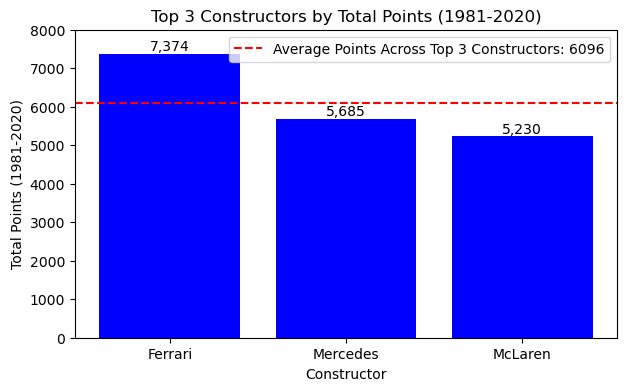

In [32]:
# Create a bar chart for the top 3 constructors
plt.figure(figsize=(7, 4))
bars = plt.bar(constructor_points_1981_2020.iloc[0:3,:]['name'], constructor_points_1981_2020.iloc[0:3,:]['total_points_1981_2020'], color='blue')
plt.axhline(y=top_3_avg_total_points_1981_2020, color='red', linestyle='--', label=f'Average Points Across Top 3 Constructors: {top_3_avg_total_points_1981_2020:.0f}')

for bar in bars:
    yval = bar.get_height()  # Get the height of the bar (total points)
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}', ha='center', va='bottom', fontsize=10)


plt.xlabel('Constructor')
plt.ylabel('Total Points (1981-2020)')
plt.title('Top 3 Constructors by Total Points (1981-2020)')
plt.ylim(0, 8000)
plt.legend()

# Display the plot
plt.show()

### Answers

| Constructor | Total Points Between 1981 and 2020 | Years Competed between 1981 and 2020 |
|-------------|------------------------------------|--------------------------------------|
| Ferrari     | 7,374                              | 40                                   |
| Mercedes    | 5,685                              | 11                                   |
| McLaren     | 5,230                              | 40                                   |

Avergage total points across top 3 constructors between 1981 and 2020 was 6,096 points


#### Ferrari, Mercedes, and McLaren had the highest number of total points between 1981 and 2020

#### Between 1981 and 2020, Ferrari got 7,374 total points, Mercedes got 5,685 total points, and McLaren got 5,230 total points (5,229.5)

#### As shown in the bar chart above, both Mercedes and McLaren are below the average of the top 3 indicating that Ferrari dominates in terms of total points accumulated between 1981 and 2020, though Mercedes and McLaren are still strong performers. Also, between 1981 and 2020, mercedes only competed for 11 years while Ferrari and McLaren both competed for all 40 years. 


## Question b

#### Top 3 constructors by total points and average total points across top 3 contructors between 2001 and 2020

In [33]:
# Getting the names of the top 3 constructors to compute the average 
top_3_constructor_2001_2020 = constructor_points_2001_2020.iloc[0:3,:]['name']

# Getting the average total points between 2001 and 2020 for top 3 constructors 
top_3_avg_total_points_2001_2020 = constructor_points_2001_2020[constructor_points_2001_2020['name'].isin(top_3_constructor_2001_2020)]['total_points_2001_2020'].mean()

# showing the top 3 constructors by total points between 2001 to 2020
display(constructor_points_2001_2020.iloc[0:3,:])

# printing the average total points for the top 3 constructors
print("Average total points across top 3 constructors between 2001 and 2020 ", top_3_avg_total_points_2001_2020)

,constructorId,name,total_points_2001_2020,distinct_years
0,6,Ferrari,5862.0,20
1,131,Mercedes,5685.0,11
2,9,Red Bull,5043.5,16


Average total points across top 3 constructors between 2001 and 2020  5530.166666666667


#### Visualization of top 3 constructors by total points and average total points across top 3 constructors between 2001 and 2020

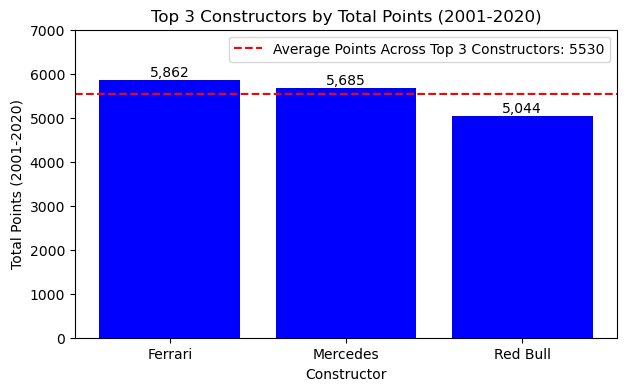

In [34]:
# Create a bar chart for the top 3 constructors

plt.figure(figsize=(7, 4))
bars = plt.bar(constructor_points_2001_2020.iloc[0:3,:]['name'], constructor_points_2001_2020.iloc[0:3,:]['total_points_2001_2020'], color='blue')
plt.axhline(y=top_3_avg_total_points_2001_2020, color='red', linestyle='--', label=f'Average Points Across Top 3 Constructors: {top_3_avg_total_points_2001_2020:.0f}')

for bar in bars:
    yval = bar.get_height()  # Get the height of the bar (total points)
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}', ha='center', va='bottom', fontsize=10)

plt.ylim(0, 7000)
plt.xlabel('Constructor')
plt.ylabel('Total Points (2001-2020)')
plt.title('Top 3 Constructors by Total Points (2001-2020)')
plt.legend() 

# Display the plot
plt.show()

### Answers
| Constructor | Total Points Between 2001 and 2020 | Years Competed Between 2001 and 2020 |
|-------------|------------------------------------|--------------------------------------|
| Ferrari     | 5,862                              | 20                                   |
| Mercedes    | 5,685                              | 11                                   |
| Red Bull    | 5,044                              | 16                                   |

Avergage total points across top 3 constructors between 2001 and 2020 was 5,530 points

#### Ferrari, Mercedes, and Red Bull had the highest number of total points between 2001 and 2020

#### Between 2001 and 2020, Ferrari got 5,862 total points, Mercedes got 5,685 total points, and Red Bull got 5,004 total points; note that Mercedes has the same number of total points between 1981 and 2020, and between 2001 and 2020 because within those time periods, they only started racing from 2010 onwards.

#### As shown in the bar chart above, both Ferrari and Mercedes are above the average total points for the top 3 indicating the close competition between them in this period. Red bull is slightly below average but is still a strong competitor. Ferrari has also been racing for more years during this time period than the other constructors. 


## Question c

#### Comparing tables and bar charts from questions a and b 

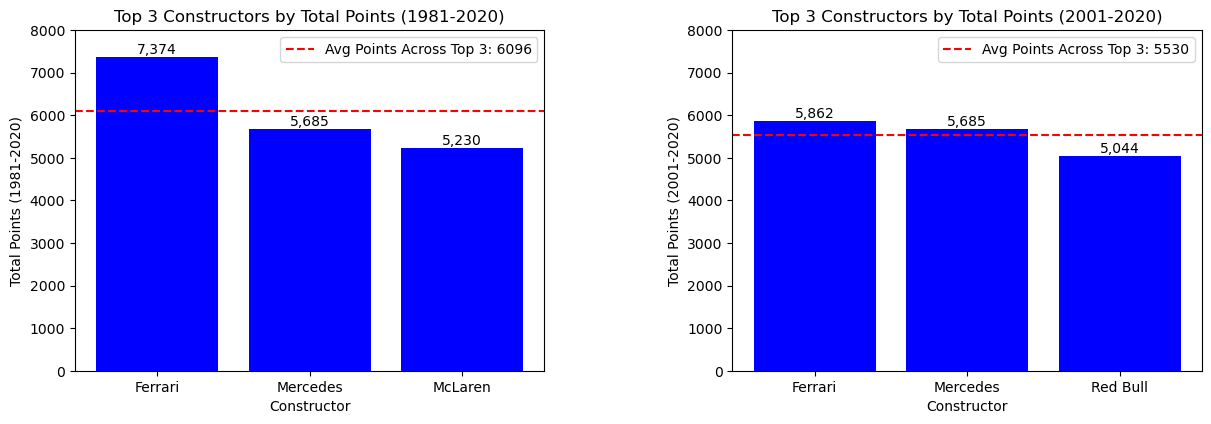

In [39]:
# Creating a plot with 1 row, 2 columns
fig, list_subfig = plt.subplots(1, 2,figsize = (12,4))


plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
# First Subfigure (Bar Chart for Top 3 Constructors 1981 - 2020)
bars = list_subfig[0].bar(constructor_points_1981_2020.iloc[0:3,:]['name'], constructor_points_1981_2020.iloc[0:3,:]['total_points_1981_2020'], color='blue')
list_subfig[0].axhline(y=top_3_avg_total_points_1981_2020, color='red', linestyle='--', label=f'Avg Points Across Top 3: {top_3_avg_total_points_1981_2020:.0f}')

for bar in bars:
    yval = bar.get_height()  # Get the height of the bar (total points)
    list_subfig[0].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}', ha='center', va='bottom', fontsize=10)

list_subfig[0].set_xlabel('Constructor')
list_subfig[0].set_ylabel('Total Points (1981-2020)')
list_subfig[0].set_title('Top 3 Constructors by Total Points (1981-2020)')
list_subfig[0].set_ylim(0, 8000)
list_subfig[0].legend()



# Second Subfigure (Bar Chart for Top 3 Constructors 2021 - 2020)
bars = list_subfig[1].bar(constructor_points_2001_2020.iloc[0:3,:]['name'], constructor_points_2001_2020.iloc[0:3,:]['total_points_2001_2020'], color='blue')
list_subfig[1].axhline(y=top_3_avg_total_points_2001_2020, color='red', linestyle='--', label=f'Avg Points Across Top 3: {top_3_avg_total_points_2001_2020:.0f}')

for bar in bars:
    yval = bar.get_height()  # Get the height of the bar (total points)
    list_subfig[1].text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}', ha='center', va='bottom', fontsize=10)

list_subfig[1].set_xlabel('Constructor')
list_subfig[1].set_ylabel('Total Points (2001-2020)')
list_subfig[1].set_title('Top 3 Constructors by Total Points (2001-2020)')
list_subfig[1].set_ylim(0, 8000)
list_subfig[1].legend()


# Display the plot
plt.show()

### Answers

McLaren dropped out of the top three during the 2001-2020 time period, while Red Bull entered the top 3 taking 3rd place. 

Ferrari remained the top constructor between both time periods, though they appear to be less dominant in the 2001-2020 time period.

Mercedes' total points remained the same between both time periods because they only started competing in 2010, which makes sense why the gap of total points from Ferrari decreased in the 2001-2020 time period since the number of years competing between the two constructors are becoming more similar. 

## Question d

In [42]:

# Querying for just years between 1981 and 2020, aggregating points by constructorId, and sorting by total points by constructor 
# Note: I am also getting the number of distinct years that each constructor competed during the time frame 
drivers_ferrari_1981_2020 = (results_merged.query("(year >= 1981) & (year <= 2020) & (name == 'Ferrari')"))['fullName'].nunique()

print("Unique Ferrari drivers between 1981 and 2020: ", drivers_ferrari_1981_2020)
                                                   



Unique Ferrari drivers between 1981 and 2020:  25


### Answers

There were 25 different drivers for Ferrari between 1981 and 2020